<a href="https://colab.research.google.com/github/renanalencar/projeto-cnn-squeezenet/blob/main/Projeto_SqzNet_vFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto de Redes Neurais 

## Referências: 



1. [Estudo sobre Câncer de Cólon utilizando a mesma base com modelod e CNN](https://www.kaggle.com/aayushrajput/lung-colon-cancer)
2. [Modelo de SqueezeNet para reconhecimento de comida](https://www.kaggle.com/kmader/food-squeezenet) 
3. [SqueezeNet no Keras](https://codelabs.developers.google.com/codelabs/keras-flowers-squeezenet#6)
4. [Entendendo Redes Convolucionais (CNNs) ](https://medium.com/neuronio-br/entendendo-redes-convolucionais-cnns-d10359f21184#:~:text=H%C3%A1%20muitas%20fun%C3%A7%C3%B5es%2C%20como%20sigmoid,quando%20comparada%20a%20outras%20fun%C3%A7%C3%B5es)
5. [Uma introdução as redes neurais convolucionais utilizando o Keras](https://medium.com/data-hackers/uma-introdu%C3%A7%C3%A3o-as-redes-neurais-convolucionais-utilizando-o-keras-41ee8dcc033e)
6. [Tutorial prático do Keras](https://cv-tricks.com/tensorflow-tutorial/keras/)
7. [Métricas de avaliação de modelo](https://gabrielschade.github.io/2019/03/12/ml-classificacao-metricas.html)


## Kaggle

In [1]:
! pip install -q kaggle
from google.colab import files
# Choose the kaggle.json file that you downloaded 
files.upload()
! mkdir ~/.kaggle
# Make directory named kaggle and copy kaggle.json file there.
! cp kaggle.json ~/.kaggle/
# Change the permissions of the file.
! chmod 600 ~/.kaggle/kaggle.json
# That's all! You can check if everything's okay by running this command.
! kaggle datasets list
# Download Data
! kaggle datasets download -d andrewmvd/lung-and-colon-cancer-histopathological-images
# Use unzip command to unzip the data:
# For example, Create a directory named train, ! mkdir train unzip train data there.
! mkdir input
# unzip train data there,
! unzip lung-and-colon-cancer-histopathological-images.zip -d input

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: input/lung_colon_image_set/lung_image_sets/lung_scc/lungscc1.jpeg  
  inflating: input/lung_colon_image_set/lung_image_sets/lung_scc/lungscc10.jpeg  
  inflating: input/lung_colon_image_set/lung_image_sets/lung_scc/lungscc100.jpeg  
  inflating: input/lung_colon_image_set/lung_image_sets/lung_scc/lungscc1000.jpeg  
  inflating: input/lung_colon_image_set/lung_image_sets/lung_scc/lungscc1001.jpeg  
  inflating: input/lung_colon_image_set/lung_image_sets/lung_scc/lungscc1002.jpeg  
  inflating: input/lung_colon_image_set/lung_image_sets/lung_scc/lungscc1003.jpeg  
  inflating: input/lung_colon_image_set/lung_image_sets/lung_scc/lungscc1004.jpeg  
  inflating: input/lung_colon_image_set/lung_image_sets/lung_scc/lungscc1005.jpeg  
  inflating: input/lung_colon_image_set/lung_image_sets/lung_scc/lungscc1006.jpeg  
  inflating: input/lung_colon_image_set/lung_image_sets/lung_scc/lungscc1007.jpeg  
  inflating: input/lung

## Erro na biblioteca keras_applications e pycm

In [2]:
!pip install keras_applications

     |████████████████████████████████| 51kB 2.1MB/s 


In [3]:
!pip install pycm

     |████████████████████████████████| 71kB 2.7MB/s 
     |████████████████████████████████| 573kB 4.8MB/s 


## Importanto as bibliotecas necessárias

In [4]:
import h5py
import numpy as np

import tensorflow as tf

from tensorflow.keras import datasets, layers, models

from keras import backend as K
from keras_applications.imagenet_utils import _obtain_input_shape
from keras.applications.vgg16 import VGG16
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.engine.topology import get_source_inputs
from keras.models import Model, model_from_json
from keras.layers import Dense,Flatten
from keras.layers import Input, Activation, concatenate
from keras.layers import Flatten, Dropout
from keras.layers import Dense,Flatten
from keras.layers import Convolution2D, MaxPooling2D,Conv2D
from keras.layers import AveragePooling2D, BatchNormalization
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.optimizers import SGD, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import get_file
from keras.utils import layer_utils
from sklearn.metrics import f1_score,recall_score, precision_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('error')
from pycm import *
   
# from visual_callbacks import AccLossPlotter

from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%matplotlib inline

Mounted at /content/drive


## Pré-processamento

O conjunto de dados contém 15.000 imagens coloridas em 3 classes, com 5.000 imagens em cada classe. O conjunto de dados é dividido em 12.000 imagens de treinamento e 3.000 imagens de teste. 

### Variáveis 

In [5]:
base_dir = '/content/drive/Shareddrives/REDES_NEURAIS_ENG74317/projeto_cnn_squeezenet/' # Diretório dos arquivos 
data_dir = '/content/input/lung_colon_image_set/lung_image_sets/' # Diretório das imagems 
width, height, nb_class = 768, 768, 3 # Dimensões da entrada
batch_size = 4 # Tamanho do lote para treinamento
shuffle = True # Sortear as amostras 
seed = 42 # Número de sementes 
nb_epoch = 50 # Número de épocas 
loss='categorical_crossentropy' # Algoritmo de optmização das Redes Convolucionais
optimizer_cnn='adam' # Algoritmo de optmização das Redes Convolucionais
optimizer_sn = 'sgd' # Algoritmo de optmização da SqueezeNet
metrics='accuracy' # Métrica utilizada 
target_size = (width, height)
input_shape =  (width, height, nb_class)

### Pré-processamento das imagens 

In [6]:
def PreProcess(data_dir,target_size,batch_size,shuffle,seed):
    
    datagen_cnn = tf.keras.preprocessing.image.ImageDataGenerator(rescale= 1. /255, validation_split = 0.2)

    train_cnn = datagen_cnn.flow_from_directory(data_dir,
                                          class_mode = "categorical",
                                          target_size = target_size,
                                          color_mode="rgb",
                                          batch_size = batch_size, 
                                          shuffle = shuffle,
                                          subset='training',
                                          seed = seed)

    validation_cnn = datagen_cnn.flow_from_directory(data_dir,
                                          class_mode = "categorical",
                                          target_size = target_size,
                                          color_mode="rgb",
                                          batch_size = batch_size, 
                                          shuffle = shuffle,
                                          subset='validation',
                                          seed = seed)

    return train_cnn, validation_cnn 

# SqueezeNet

### Modelo SqueezeNet

In [7]:
sq1x1 = "squeeze1x1"
exp1x1 = "expand1x1"
exp3x3 = "expand3x3"
relu = "relu_"

WEIGHTS_PATH = "https://github.com/rcmalli/keras-squeezenet/releases/download/v1.0/squeezenet_weights_tf_dim_ordering_tf_kernels.h5"
WEIGHTS_PATH_NO_TOP = "https://github.com/rcmalli/keras-squeezenet/releases/download/v1.0/squeezenet_weights_tf_dim_ordering_tf_kernels_notop.h5"

def fire_module(x, fire_id, squeeze=16, expand=64):
    s_id = 'fire' + str(fire_id) + '/'

    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = 3
    
    x = Convolution2D(squeeze, (1, 1), padding='valid', name=s_id + sq1x1)(x)
    x = Activation('relu', name=s_id + relu + sq1x1)(x)

    left = Convolution2D(expand, (1, 1), padding='valid', name=s_id + exp1x1)(x)
    left = Activation('relu', name=s_id + relu + exp1x1)(left)

    right = Convolution2D(expand, (3, 3), padding='same', name=s_id + exp3x3)(x)
    right = Activation('relu', name=s_id + relu + exp3x3)(right)

    x = concatenate([left, right], axis=channel_axis, name=s_id + 'concat')
    return x


def Model_SqzNet(include_top=True, weights='imagenet', 
               input_tensor=None, input_shape=None,
               pooling=None,
               use_bn_on_input = False,
               classes=1000):
    """Instantiates the SqueezeNet architecture.
    """
        
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    if weights == 'imagenet' and classes != 1000:
        raise ValueError('If using `weights` as imagenet with `include_top`'
                         ' as true, `classes` should be 1000')


    input_shape = _obtain_input_shape(input_shape,
                                      default_size=227,
                                      min_size=48,
                                      data_format=K.image_data_format(),
                                      require_flatten=include_top)

    if input_tensor is None:
        raw_img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    if use_bn_on_input:
        img_input = BatchNormalization()(raw_img_input)
    else:
        img_input = raw_img_input

    x = Convolution2D(64, (3, 3), strides=(2, 2), padding='valid', name='conv1')(img_input)
    x = Activation('relu', name='relu_conv1')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1')(x)

    x = fire_module(x, fire_id=2, squeeze=16, expand=64)
    x = fire_module(x, fire_id=3, squeeze=16, expand=64)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool3')(x)

    x = fire_module(x, fire_id=4, squeeze=32, expand=128)
    x = fire_module(x, fire_id=5, squeeze=32, expand=128)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool5')(x)

    x = fire_module(x, fire_id=6, squeeze=48, expand=192)
    x = fire_module(x, fire_id=7, squeeze=48, expand=192)
    x = fire_module(x, fire_id=8, squeeze=64, expand=256)
    x = fire_module(x, fire_id=9, squeeze=64, expand=256)
    
    if include_top:
    
        x = Dropout(0.5, name='drop9')(x)

        x = Convolution2D(classes, (1, 1), padding='valid', name='conv10')(x)
        x = Activation('relu', name='relu_conv10')(x)
        x = GlobalAveragePooling2D()(x)
        x = Activation('softmax', name='loss')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling=='max':
            x = GlobalMaxPooling2D()(x)
        elif pooling==None:
            pass
        else:
            raise ValueError("Unknown argument for 'pooling'=" + pooling)

    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input

    model = Model(inputs, x, name='squeezenet')

    if weights == 'imagenet':
        if include_top:
            weights_path = get_file('squeezenet_weights_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH,
                                    cache_subdir='models')
        else:
            weights_path = get_file('squeezenet_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                    WEIGHTS_PATH_NO_TOP,
                                    cache_subdir='models')
            
        model.load_weights(weights_path)
        if K.backend() == 'theano':
            layer_utils.convert_all_kernels_in_model(model)

        if K.image_data_format() == 'channels_first':

            if K.backend() == 'tensorflow':
                print('You are using the TensorFlow backend, yet you '
                              'are using the Theano '
                              'image data format convention '
                              '(`image_data_format="channels_first"`). '
                              'For best performance, set '
                              '`image_data_format="channels_last"` in '
                              'your Keras config '
                              'at ~/.keras/keras.json.')
    return model

### Função para compilar o modelo da SqueezeNet

In [8]:
def Compile_Model_SqzNet(input_shape, nb_class, loss, optimizer_sn, metrics):
 
  model_sn = Model_SqzNet(input_shape=input_shape,  weights=None, classes = nb_class)
  sgd = SGD(lr=0.001, decay=0.0002, momentum=0.9, nesterov=True)
  opt = RMSprop(lr=0.0001, decay=1e-6)
  model_sn.compile(loss=loss, optimizer=opt, metrics=metrics)
  model_sn.summary()

  return model_sn

### Função para treinamento  da SqueezeNet

In [9]:
def Train_Model_SqzNet(model_sn, train_cnn, nb_epoch, validation_cnn):
    
    history_sn = model_sn.fit(train_cnn, epochs = nb_epoch,  validation_data=validation_cnn)

    # salvar modelo para posterior avaliação      
    model_json = model_sn.to_json()
    model_name = "Modelo_SqzNet"
    with open(base_dir+'models/' +model_name+".json", "w") as json_file:
      json_file.write(model_json)
    model_sn.save_weights(base_dir+'weights/'+model_name+'.h5')

    return history_sn

### Função para execuação  da SqueezeNet

In [10]:
def Execute_Model_SqzNet():
    
    train_cnn, validation_cnn = PreProcess(data_dir,target_size,batch_size,shuffle,seed)
    model_sn = Compile_Model_SqzNet(input_shape, nb_class, loss, optimizer_sn, metrics)
    history_sn = Train_Model_SqzNet(model_sn, train_cnn, nb_epoch, validation_cnn)

    # Plotar a curva de aprendizagem
    history_dict = history_sn.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    accuracy = history_dict['accuracy']
    val_accuracy = history_dict['val_accuracy']
    
    epochs = range(1, len(loss_values) + 1)
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    # Plotar a Perdas vs Épocas
    ax.plot(epochs, loss_values, 'bo', label='Perda de treinamento')
    ax.plot(epochs, val_loss_values, 'b', label='Perda de validação')
    ax.set_title('Perdas de Treinamento & Validação', fontsize=16)
    ax.set_xlabel('Épocas', fontsize=16)
    ax.set_ylabel('Perdas', fontsize=16)
    ax.legend()

    ax.figure.savefig(base_dir+'graphs/Curva_de_aprendizagem_SqzNet.png')

### Função para avaliação  da SqueezeNet

In [11]:
def Evaluate_Model_SqzNet():
    
    train_cnn, validation_cnn = PreProcess(data_dir,target_size,batch_size,shuffle,seed)

    # Recuperando o modelo Treinado da CNN
    with open(base_dir+'models/Modelo_SqzNet.json','r') as modelo:
      json = modelo.read()
    model_sn = model_from_json(json)

    # Recuperando os pesos do treinamento da CNN
    model_sn.load_weights(base_dir+'weights/Modelo_SqzNet.h5') 

    Y_pred = model_sn.predict(validation_cnn)
    y_pred = np.argmax(Y_pred, axis=1)
    
    cm = ConfusionMatrix(actual_vector=validation_cnn.classes, predict_vector=y_pred)
    
    print('                 Aca\tN\tSCC')
    print('A sensibilidade :{}\t{}\t{}'.format(cm.TPR[0],cm.TPR[1],cm.TPR[2]))    
    print('A especificidade:{}\t{}\t{}'.format(cm.TNR[0],cm.TNR[1],cm.TNR[2]))

        # guardar o resultado das métricas
    model_name = "Modelo_SqzNet"
    with open(base_dir+'results/'+model_name+'.txt', 'w') as arquivo:
      print('                 Aca\tN\tSCC', file=arquivo)
      print('A sensibilidade :{}\t{}\t{}'.format(cm.TPR[0],cm.TPR[1],cm.TPR[2]), file=arquivo)    
      print('A especificidade:{}\t{}\t{}'.format(cm.TNR[0],cm.TNR[1],cm.TNR[2]), file=arquivo)

    cm.plot(cmap=plt.cm.Greens,number_label=True,plot_lib="matplotlib")

    fpr = {}
    tpr = {}
    thresh ={}

    n_class = 3

    for i in range(n_class):    
        fpr[i], tpr[i], thresh[i] = roc_curve(validation_cnn.classes, Y_pred[:,i], pos_label=i)

    plt.figure()
    plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
    plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
    plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
    plt.title('Multiclass ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive rate')
    plt.legend(loc='best')
    plt.show()
    plt.savefig(base_dir+'graphs/Multiclass_ROC_SqzNet.png',dpi=300); 

### Chamada para execução da SqueezeNet

Found 12000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.
Model: "squeezenet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 768, 768, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 383, 383, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
relu_conv1 (Activation)         (None, 383, 383, 64) 0           conv1[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 191, 191, 64) 0           relu_conv1[0][0]                 
____

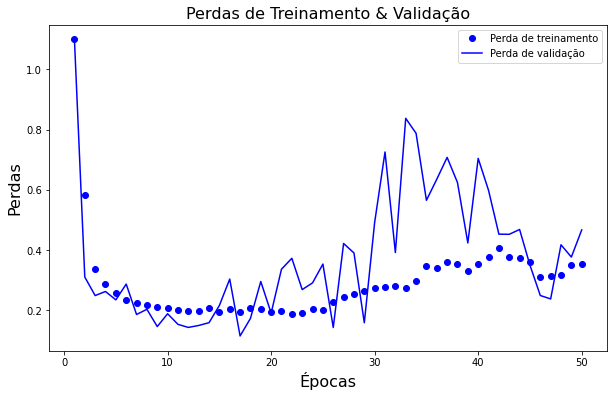

In [12]:
Execute_Model_SqzNet()

### Chamada para avaliação da SqueezeNet

Found 12000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.
                 Aca	N	SCC
A sensibilidade :0.276	0.255	0.472
A especificidade:0.727	0.754	0.5205


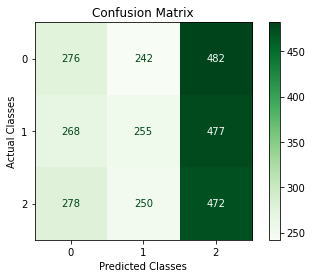

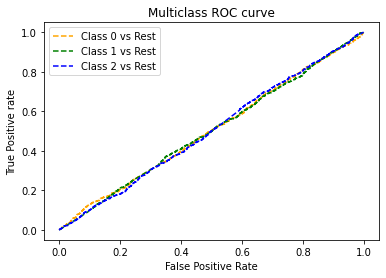

<Figure size 432x288 with 0 Axes>

In [13]:
Evaluate_Model_SqzNet()